#imports

IMPORTS

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2, math, os, torch, argparse
from google.colab.patches import cv2_imshow

In [ ]:
import numpy as np
def make_colorwheel():
    """
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf

    Code follows the original C++ source code of Daniel Scharstein.
    Code follows the the Matlab source code of Deqing Sun.

    Returns:
        np.ndarray: Color wheel
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_uv_to_colors(u, v, convert_to_bgr=False):
    """
    Applies the flow color wheel to (possibly clipped) flow components u and v.

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    Args:
        u (np.ndarray): Input horizontal flow of shape [H,W]
        v (np.ndarray): Input vertical flow of shape [H,W]
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)
    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]
    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi
    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0
    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1
        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range
        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)
    return flow_image


def flow_to_image(flow_uv, clip_flow=None, convert_to_bgr=False):
    """
    Expects a two dimensional flow image of shape.

    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        clip_flow (float, optional): Clip maximum of flow values. Defaults to None.
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'
    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)
    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]
    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)
    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)
    return flow_uv_to_colors(u, v, convert_to_bgr)

#code

DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/Shareddrives/Colab/DVPA_Assignment/Assignment_2/00001.zip

Mounted at /content/drive
Archive:  /content/drive/Shareddrives/Colab/DVPA_Assignment/Assignment_2/00001.zip
 extracting: 00001/CameraExtrinsics.csv  
 extracting: 00001/rgb/0000.png      
 extracting: 00001/rgb/0001.png      
 extracting: 00001/rgb/0002.png      
 extracting: 00001/rgb/0003.png      
 extracting: 00001/rgb/0004.png      
 extracting: 00001/rgb/0005.png      
 extracting: 00001/rgb/0006.png      
 extracting: 00001/rgb/0007.png      
 extracting: 00001/rgb/0008.png      
 extracting: 00001/rgb/0009.png      
 extracting: 00001/rgb/0010.png      
 extracting: 00001/rgb/0011.png      
 extracting: 00001/rgb/0012.png      
 extracting: 00001/rgb/0013.png      
 extracting: 00001/rgb/0014.png      
 extracting: 00001/rgb/0015.png      
 extracting: 00001/rgb/0016.png      
 extracting: 00001/rgb/0017.png      
 extracting: 00001/rgb/0018.png      
 extracting: 00001/rgb/0019.png      
 extracting: 00001/rgb/0020.png      
 extracting: 00001/rgb/0021.png      
 extracting: 

RAFT MODEL

In [ ]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 28.89 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
cd /content/RAFT/core

/content/RAFT/core


In [ ]:
!/content/RAFT/download_models.sh

--2023-10-22 19:23:15--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M   105MB/s    in 0.7s    

2023-10-22 19:23:17 (105 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   


In [ ]:
from raft import RAFT

In [ ]:
cd /content

/content


In [ ]:
DEVICE = 'cuda'
parser = argparse.ArgumentParser()
parser.add_argument('--model',default='/content/RAFT/core/models/raft-things.pth', help="restore checkpoint")
parser.add_argument('--path', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
parser.add_argument("-f", "--file", required=False)
args = parser.parse_args()
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))
model = model.module
model.to(DEVICE)

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

FUNCTIONS

In [ ]:
from PIL import Image
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)
def move_flow(a,b,t,frame0,frame1):
    y,x = np.float32(np.meshgrid(np.arange(frame0.shape[1]),np.arange(frame0.shape[0])))
    x1,y1 = np.round(np.float32(x+t*a)).astype("uint32"),np.round(np.float32(y+t*b)).astype("uint32")

    U_x = np.zeros(frame0.shape, dtype = np.float32)
    tmp_x = np.zeros(frame0.shape, dtype = np.float32)
    U_y = np.zeros(frame0.shape, dtype = np.float32)
    tmp_y = np.zeros(frame0.shape, dtype = np.float32)

    # Occlusion mask
    O0= np.zeros(frame0.shape)
    O1 = np.ones(frame0.shape)


    for i in range(frame0.shape[0]):
      for j in range(frame0.shape[1]):

######################Creating U_x########################
        k,l = min(x1[i,j],frame1.shape[0]-1),min(y1[i,j],frame1.shape[1]-1)

        O1[k,l] = 0
        diff = abs(frame0[i,j] - frame1[k,l])
        # If U_x not updated
        if not U_x[k,l]:
          U_x[k,l] = a[i,j]
          tmp_x[k,l] = diff
        else:
        # If U_x already updated
          if diff<tmp_x[k,l]:
            tmp_x[k,l] = diff
            U_x[k,l] = a[i,j]

#######################Creating U_y########################
        m,n = min(x1[i,j],frame1.shape[0]-1),min(y1[i,j],frame1.shape[1]-1)

        diff2 = abs(frame0[i,j] - frame1[m,n])
        if not U_y[m,n]:
          U_y[m,n] = b[i,j]
          tmp_y[m,n] = diff2
        else:
          if diff2<tmp_y[m,n]:
            tmp_y[m,n] = diff2
            U_y[m,n] = b[i,j]

    return U_x, U_y

def move_frames(frame0,a,b):
    h, w = frame0.shape[:2]
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    x1, y1 = np.clip(x+a, 0, w-1), np.clip(y+b, 0, h-1)
    warped_image = cv2.remap(frame0,x1.astype(np.float32),y1.astype(np.float32),interpolation=cv2.INTER_LINEAR)
    return warped_image


In [ ]:
def create_frames(K,imgg0,imgg1,itr):
  grey_img0 = cv2.cvtColor(imgg0, cv2.COLOR_BGR2GRAY)
  grey_img1 = cv2.cvtColor(imgg1, cv2.COLOR_BGR2GRAY)
  img0, img1 = torch.tensor(imgg0), torch.tensor(imgg1)
  img0, img1 = img0.permute((2,0,1)).unsqueeze(0), img1.permute((2,0,1)).unsqueeze(0)

  with torch.no_grad():
    img0 = img0.to('cuda')
    img1 = img1.to('cuda')
    fr0 = model(img0,img1,itr,test_mode=True)[1].cpu().numpy()
    fr1 = model(img1,img0,itr,test_mode=True)[1].cpu().numpy()
  a_f,b_f,a_b,b_b = fr0[0][0], fr0[0][1], fr1[0][0], fr1[0][1]
  frames = []
  for i in range(K):
    t = (i+1)/(K+1)
    a,b = move_flow(a_f,b_f,t,grey_img0,grey_img1)
    a = (1-t)*a
    b = (1-t)*b
    frame_f = (t*(move_frames(imgg1,a,b)))
    a,b = move_flow(a_b,b_b,1-t,grey_img1,grey_img0)
    a = t*a
    b = t*b
    frame_b = ((1-t)*(move_frames(imgg0,a,b)))
    frame = (frame_f + frame_b).astype('uint8')
    frames.append(frame)
  return frames

#Q1.(a) Pre-trained RAFT model

### K = 1

Getting interpolated frame between 2 frames

0


<ipython-input-14-f19e01883dad>:23: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = abs(frame0[i,j] - frame1[k,l])
<ipython-input-14-f19e01883dad>:37: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = abs(frame0[i,j] - frame1[m,n])


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46


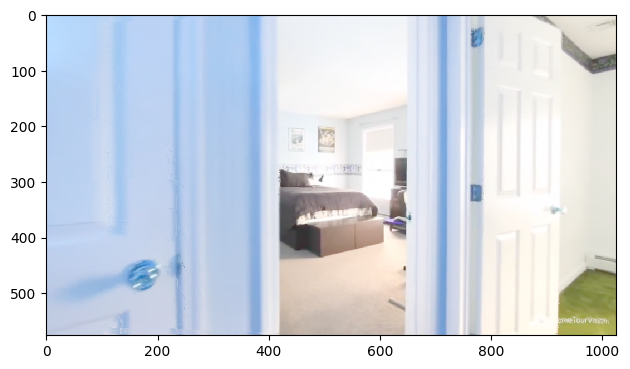

In [ ]:
frame_dir = "/content/00001/rgb"
frame_list=[]
orig_frames=[]
new_frames = []
K=1
itr = 24
for frame_name in sorted(os.listdir(frame_dir)):
  frame_path = os.path.join(frame_dir,frame_name)
  frame = cv2.imread(frame_path)
  frame_list.append(frame)

for i in range(0,len(frame_list)-K-1,K+1):
  print(i)
  new_frames.append(frame_list[i])
  f = create_frames(K,frame_list[i],frame_list[i+K+1],itr)  # K = 1
  new_frames+=f
  io.imshow(f[0])
  for j in range(i,i+K+1):
    orig_frames.append(frame_list[i])
new_frames.append(frame_list[i])
orig_frames.append(frame_list[i])

In [ ]:
len(new_frames), len(orig_frames)

(49, 49)

Creating video from frames

FUNCTION

In [ ]:
def save_frames_as_video(frames, output_video_path, frame_rate, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, frame_size)
    for frame in frames:
        out.write(frame)
    out.release()

VIDEO CREATION

In [ ]:
frame_rate = 30
frame_size = (1024, 576)
output_video_path = 'output_video.mp4'
save_frames_as_video(new_frames, output_video_path, frame_rate, frame_size)
output_video_path = 'orig_video.mp4'
save_frames_as_video(orig_frames, output_video_path, frame_rate, frame_size)

## LPIPS

In [ ]:
!pip install lpips
import lpips
loss_fn_vgg = lpips.LPIPS(net='vgg')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.5MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
d = 0
K=1
count = 0
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    img0 = (new_frames[i]/255.0)* 2.0 - 1.0
    img0 = torch.from_numpy(img0)
    img0 = torch.permute(img0,(2,0,1))
    img0 = torch.unsqueeze(img0,0)
    img0 = img0.to(torch.float32)

    img1 = (orig_frames[i]/255.0)* 2.0 - 1.0
    img1 = torch.from_numpy(img1)
    img1 = torch.permute(img1,(2,0,1))
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.to(torch.float32)

    d = d + loss_fn_vgg(img0, img1).item()

#K=1
#LPIPS: Pre-trained RAFT model
d = d/count
print(d)

0.1334724829842647

### PSNR

In [ ]:
psnr = 0
count=0
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    mse = np.mean((new_frames[i] - orig_frames[i]) ** 2)
    psnr = psnr + 10 * np.log10((255 ** 2) / (mse+0.0001))
#PSNR
psnr = psnr/count
print(psnr)

35.87168858156816

## K = 2

K = 2 means two interpolated frame between 2 frames (a little different notation from question)

In [ ]:
frame_dir = "/content/00001/rgb"
frame_list=[]
orig_frames=[]
new_frames = []
K=2
itr = 24
for frame_name in sorted(os.listdir(frame_dir)):
  frame_path = os.path.join(frame_dir,frame_name)
  frame = cv2.imread(frame_path)
  frame_list.append(frame)

for i in range(0,len(frame_list)-K-1,K+1):
  print(i)
  new_frames.append(frame_list[i])
  f = create_frames(K,frame_list[i],frame_list[i+K+1],itr)  # K = 2
  new_frames+=f

  for j in range(i,i+K+1):
    orig_frames.append(frame_list[i])
new_frames.append(frame_list[i])
orig_frames.append(frame_list[i])

0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-13-923c1e314c43>:22: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = abs(frame0[i,j] - frame1[k,l])
<ipython-input-13-923c1e314c43>:36: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = abs(frame0[i,j] - frame1[m,n])


3
6
9
12
15
18
21
24
27
30
33
36
39
42
45


### Saving Videos

In [ ]:
frame_rate = 30
frame_size = (1024, 576)
output_video_path = 'output_video.mp4'
save_frames_as_video(new_frames, output_video_path, frame_rate, frame_size)
output_video_path = 'orig_video.mp4'
save_frames_as_video(orig_frames, output_video_path, frame_rate, frame_size)

LPIPS

In [ ]:
d = 0
K=2
count = 0
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    img0 = (new_frames[i]/255.0)* 2.0 - 1.0
    img0 = torch.from_numpy(img0)
    img0 = torch.permute(img0,(2,0,1))
    img0 = torch.unsqueeze(img0,0)
    img0 = img0.to(torch.float32)

    img1 = (orig_frames[i]/255.0)* 2.0 - 1.0
    img1 = torch.from_numpy(img1)
    img1 = torch.permute(img1,(2,0,1))
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.to(torch.float32)

    d = d + loss_fn_vgg(img0, img1).item()
d = d/count

#LPIPS
print(d)

0.1758967568166554

### PSNR

In [ ]:
psnr = 0
count=0
K=2
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    mse = np.mean((new_frames[i] - orig_frames[i]) ** 2)
    psnr = psnr + 10 * np.log10((255 ** 2) / (mse+0.0001))
psnr = psnr/count

#PSNR
print(psnr)

34.9473165853244

#Q1.(b) Fine tuning the number of steps

K=1

In [ ]:
def calc_error(K,image0,image1,iteration):
  grey_img0 = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY)
  grey_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  img0 = torch.tensor(image0).permute((2,0,1)).unsqueeze(0).to('cuda')
  img1 = torch.tensor(image1).permute((2,0,1)).unsqueeze(0).to('cuda')
  with torch.no_grad():
    f0 = model(img0,img1,iteration)
    f1 = model(img1,img0,iteration)
  a_f,b_f = f0[len(f0)-1][0].cpu().numpy()
  a_b,b_b = f1[len(f1)-1][0].cpu().numpy()
  temp_img0 = move_frames(image1,a_f,b_f)
  temp_img1 = move_frames(image0,a_b,b_b)
  e = np.mean((temp_img0 - image0) ** 2 + (temp_img1 - image1) ** 2)
  return(e)

In [ ]:
frame_dir = "/content/00001/rgb"
frame_list=[]
errors=[]
index = []
K=1
for frame_name in sorted(os.listdir(frame_dir)):
  frame_path = os.path.join(frame_dir,frame_name)
  frame = cv2.imread(frame_path)
  frame_list.append(frame)
for iteration in range(1,30,3):
  index.append(iteration)
  f = 0
  for i in range(0,len(frame_list)-K-1,K+1):
    f = f + calc_error(K,frame_list[i],frame_list[i+K+1],iteration)
  errors.append(f)

In [ ]:
errors

[446.384686505353,
 275.6333996808088,
 262.60130592628764,
 260.8581718162254,
 259.5508128978588,
 259.0934600830078,
 258.9093791820385,
 259.1522380687572,
 259.3984052870009,
 259.7264020001447]

In [ ]:
index

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28]

In [ ]:
index[np.argmin(errors)]

19

In [ ]:
frame_dir = "/content/00001/rgb"
frame_list=[]
orig_frames=[]
new_frames = []
K=1
iteration = index[np.argmin(errors)]
for frame_name in sorted(os.listdir(frame_dir)):
  frame_path = os.path.join(frame_dir,frame_name)
  frame = cv2.imread(frame_path)
  frame_list.append(frame)

for i in range(0,len(frame_list)-K-1,K+1):
  print(i)
  new_frames.append(frame_list[i])
  f = create_frames(K,frame_list[i],frame_list[i+K+1],iteration)  # K = 2
  new_frames+=f
  for j in range(i,i+K+1):
    orig_frames.append(frame_list[i])
new_frames.append(frame_list[i])
orig_frames.append(frame_list[i])

0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-19-af1510e5afa0>:27: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = abs(frame0[i,j] - frame1[k,l])
<ipython-input-19-af1510e5afa0>:41: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = abs(frame0[i,j] - frame1[m,n])


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46


In [ ]:
frame_rate = 30
frame_size = (1024, 576)
output_video_path = 'output_video_itr_k1.mp4'
save_frames_as_video(new_frames, output_video_path, frame_rate, frame_size)

LPIPS and PSNR K=1

In [ ]:
d = 0
K=1
count = 0
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    img0 = (new_frames[i]/255.0)* 2.0 - 1.0
    img0 = torch.from_numpy(img0)
    img0 = torch.permute(img0,(2,0,1))
    img0 = torch.unsqueeze(img0,0)
    img0 = img0.to(torch.float32)

    img1 = (orig_frames[i]/255.0)* 2.0 - 1.0
    img1 = torch.from_numpy(img1)
    img1 = torch.permute(img1,(2,0,1))
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.to(torch.float32)
    d = d + loss_fn_vgg(img0, img1).item()
d = d/count

#LPIPS Iteration= 19 K=1
print(d)

0.13369015821566185


In [ ]:
psnr = 0
count=0
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    mse = np.mean((new_frames[i] - orig_frames[i]) ** 2)
    psnr = psnr + 10 * np.log10((255 ** 2) / (mse+0.0001))
psnr = psnr/count

#PSNR Iteration= 19 K=1
print(psnr)

35.87207882600881


In [ ]:
frame_dir = "/content/00001/rgb"
frame_list=[]
errors=[]
index = []
K=2
for frame_name in sorted(os.listdir(frame_dir)):
  frame_path = os.path.join(frame_dir,frame_name)
  frame = cv2.imread(frame_path)
  frame_list.append(frame)
for iteration in range(1,60,3):
  index.append(iteration)
  f = 0
  for i in range(0,len(frame_list)-K-1,K+1):
    f = f + calc_error(K,frame_list[i],frame_list[i+K+1],iteration)
  errors.append(f)

In [ ]:
errors

[415.3805010760272,
 263.9741403085214,
 247.8069842303241,
 244.6069669370298,
 243.58659814905235,
 242.85349075882522,
 242.7734742341218,
 242.62400026674626,
 242.479732937283,
 242.32536089861833,
 243.25370675546156,
 243.63279950177227,
 243.72389842845777,
 244.14860195583768,
 244.09744884349684,
 244.1685836226852,
 244.1835259331597,
 244.32931405526614,
 244.36199894657847,
 244.33543000397862]

In [ ]:
index

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58]

In [ ]:
index[np.argmin(errors)]

28

In [ ]:
frame_dir = "/content/00001/rgb"
frame_list=[]
orig_frames=[]
new_frames = []
K=2
itr = index[np.argmin(errors)]
for frame_name in sorted(os.listdir(frame_dir)):
  frame_path = os.path.join(frame_dir,frame_name)
  frame = cv2.imread(frame_path)
  frame_list.append(frame)

for i in range(0,len(frame_list)-K-1,K+1):
  print(i)
  new_frames.append(frame_list[i])
  f = create_frames(K,frame_list[i],frame_list[i+K+1],itr)  # K = 2
  new_frames+=f
  for j in range(i,i+K+1):
    orig_frames.append(frame_list[i])
new_frames.append(frame_list[i])
orig_frames.append(frame_list[i])

0


<ipython-input-19-af1510e5afa0>:27: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = abs(frame0[i,j] - frame1[k,l])
<ipython-input-19-af1510e5afa0>:41: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = abs(frame0[i,j] - frame1[m,n])


3
6
9
12
15
18
21
24
27
30
33
36
39
42
45


LPIPS and PSNR K=2

In [ ]:
d = 0
K=2
count = 0
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    img0 = (new_frames[i]/255.0)* 2.0 - 1.0
    img0 = torch.from_numpy(img0)
    img0 = torch.permute(img0,(2,0,1))
    img0 = torch.unsqueeze(img0,0)
    img0 = img0.to(torch.float32)

    img1 = (orig_frames[i]/255.0)* 2.0 - 1.0
    img1 = torch.from_numpy(img1)
    img1 = torch.permute(img1,(2,0,1))
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.to(torch.float32)

    d = d + loss_fn_vgg(img0, img1).item()
d = d/count
#LPIPS Iteration= 28 K=2
print(d)

0.17582615790888667


In [ ]:
psnr = 0
count=0
K=2
for j in range(0,len(orig_frames),K+1):
  for i in range(j+1,j+K+1):
    if(i>=len(orig_frames)):
      break
    count+=1
    mse = np.mean((new_frames[i] - orig_frames[i]) ** 2)
    psnr = psnr + 10 * np.log10((255 ** 2) / (mse+0.0001))
psnr = psnr/count
#PSNR Iteration= 28 K=2
print(psnr)

34.94910554392438


VIDEO CREATION

In [ ]:
frame_rate = 30
frame_size = (1024, 576)
output_video_path = 'output_video_itr_k2.mp4'
save_frames_as_video(new_frames, output_video_path, frame_rate, frame_size)

In [ ]:
while True:pass